### This notebook will take a L1 UIUC file and turn it into the data products in level 2.1

#### This is a first step at modularizing the code

In [185]:
%pylab inline
from Scientific.IO.NetCDF import NetCDFFile as Dataset
from datetime import datetime, timedelta
from pyglow import pyglow
from mpl_toolkits.basemap import Basemap
import os
import glob
from scipy.interpolate import griddata
import subprocess
import MIGHTI_L2
import ICON
reload(ICON)
from scipy.stats import nanmedian

import sys
import time as timemod
from IPython.display import display, clear_output

reload(MIGHTI_L2)

# Change matplotlib defaults
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = (4,3)
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['ytick.labelsize'] = 'small'
matplotlib.rcParams['legend.fancybox'] = 'True'
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.numpoints'] = 1

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Read L1_UIUC file 

In [186]:
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/MIGHTI_L1_UIUC_red_001.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/UIUCL1/ICON_MIGHTI_B_ray_UT_330.000.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150522/UIUCL1/ICON_MIGHTI_A_ray_UT_1005.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150522/UIUCL1/ICON_MIGHTI_A_ray_UT_1035.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/UIUCL1/ICON_MIGHTI_B_ray_UT_1080.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160117/UIUCL1/ICON_MIGHTI_A_ray_UT_3615.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160209/UIUCL1/ICON_MIGHTI_B_ray_UT_2610.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160209/UIUCL1/ICON_MIGHTI_B_ray_UT_1350.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160118/UIUCL1/ICON_MIGHTI_B_ray_UT_2610.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160118/UIUCL1/ICON_MIGHTI_A_ray_UT_2355.00.npz'
#L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160229/UIUCL1/ICON_MIGHTI_A_ray_UT_195.000.npz'
#L1_uiuc_fn =  '/home/bhardin2/MIGHTI/Englandfiles/AB_20160323/UIUCL1/ICON_MIGHTI_A_ray_UT_1035.00.npz'
L1_uiuc_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160516/Output_1/UIUCL1/ICON_MIGHTI_B_ray_UT_1380.00.npz'

In [187]:
npzfile = load(L1_uiuc_fn)

#########################  Load parameters from file #################################
Ii = npzfile['Ii']
Ir = npzfile['Ir']
emission_color = npzfile['emission_color'].item()
datetime_created = npzfile['datetime_created']
source_files = npzfile['source_files']
time = npzfile['time'].item()
exp_time = npzfile['exp_time']

# Load parameters which are averaged from start to end of exposure.
icon_alt = (npzfile['icon_alt_start'] + npzfile['icon_alt_end'])/2
icon_lat = (npzfile['icon_lat_start'] + npzfile['icon_lat_end'])/2
icon_lon = MIGHTI_L2.circular_mean(npzfile['icon_lon_start'], npzfile['icon_lon_end'])
mighti_ecef_vectors = (npzfile['mighti_ecef_vectors_start'] + npzfile['mighti_ecef_vectors_end'])/2
tang_alt = (npzfile['tang_alt_start'] + npzfile['tang_alt_end'])/2
tang_lat = (npzfile['tang_lat_start'] + npzfile['tang_lat_end'])/2
tang_lon = MIGHTI_L2.circular_mean(npzfile['tang_lon_start'], npzfile['tang_lon_end'])
icon_ecef_ram_vector = (npzfile['icon_ecef_ram_vector_start'] + npzfile['icon_ecef_ram_vector_end'])/2
icon_velocity = (npzfile['icon_velocity_start'] + npzfile['icon_velocity_end'])/2
start_path = npzfile['interferometer_start_path']
end_path   = npzfile['interferometer_end_path']

npzfile.close()

######################### Load instrument constants ###########################
instrument = MIGHTI_L21.get_instrument_constants(emission_color)

################# Perform miscellaneous transformations ############################
Iraw         = Ir + 1j*Ii

print 'Reading file %s' % L1_uiuc_fn
print 'Created %s' % datetime_created
print 'Shape: %s' % str(shape(Ii))

Reading file /home/bhardin2/MIGHTI/Englandfiles/AB_20160516/Output_1/UIUCL1/ICON_MIGHTI_B_ray_UT_1380.00.npz
Created 2016-05-16 09:27:01.955054
Shape: (101, 396)


## Perform processing

In [188]:
zero_phase_addition = 0.0
print zero_phase_addition

0.0


In [189]:
reload(MIGHTI_L2)

#### Remove Satellite Velocity
I = MIGHTI_L2.remove_satellite_velocity(Iraw, icon_velocity, icon_ecef_ram_vector, mighti_ecef_vectors, 
                                         instrument['phase_to_wind_factor'], show_plot=False)

#### Warn about phase discontuity, if applicable
MIGHTI_L2.find_phase_discontinuity(I, instrument['min_amp'], instrument['Nignore'])

#### Determine geographical locations of inverted wind
lat, lon, alt = MIGHTI_L2.attribute_measurement_location(tang_lat, tang_lon, tang_alt)

#### Onion-peel interferogram (NOTE: option to account for local horizontal projection)
Ip = MIGHTI_L2.perform_inversion(I, tang_alt, icon_alt, account_for_local_projection=True, top_layer='exp',
                                  zero_phase=instrument['zero_phase'], phase_offset=instrument['phase_offset'],
                                  Nignore=instrument['Nignore'])

#### Extract wind
v_inertial, ve_inertial, a, ae, p = MIGHTI_L2.extract_wind(Ip, instrument['zero_phase'] + zero_phase_addition,
                                                                instrument['phase_offset'],
                                                                instrument['min_amp'], 
                                                                instrument['Nignore'],
                                                                instrument['phase_to_wind_factor'])

#### Calculate azimuth angles at measurement locations
sat_latlonalt = np.array([icon_lat, icon_lon, icon_alt])
az = MIGHTI_L2.los_az_angle(sat_latlonalt, lat, lon, alt)

#### Transform from inertial to rotating coordinate frame
v = MIGHTI_L2.remove_Earth_rotation(v_inertial, az, lat, lon, alt)
ve = ve_inertial.copy() # No uncertainty added in this process

#### Make values outside of spec altitudes equal to nan
#pt = pyglow.Point(time, np.mean(tang_lat), np.mean(tang_lon), np.mean(tang_alt))
#sza = ICON.get_solar_zenith_angle(pt)
#day = sza < 90.
day = True # For now let's use daytime specs
# Actual spec is red day 170-300, red night 200-300, green day 90-170, green night 90-105
if day:
    alt_spec = {'red':(170,330), 'green':(90,170)}
else:
    alt_spec = {'red':(200,330), 'green':(90,105)}
altmin, altmax = alt_spec[emission_color]
v[alt < altmin] = np.nan
v[alt > altmax] = np.nan

### Save L2.1 file

In [190]:
np.savez('/home/bhardin2/MIGHTI/example_level21.npz',
         los_wind                     = v,
         los_wind_error               = ve,
         lat                          = lat,
         lon                          = lon,
         alt                          = alt,
         time                         = time,
         exp_time                     = exp_time,
         az                           = az,
         emission_color               = emission_color,
         resolution_along_track       = None, # TODO
         resolution_cross_track       = None, # TODO
         resolution_alt               = None, # TODO
         icon_alt                     = icon_alt,
         icon_lat                     = icon_lat,
         icon_lon                     = icon_lon,
         fringe_amplitude             = a,
         fringe_amplitude_error       = ae,
         mighti_ecef_vectors          = mighti_ecef_vectors,
         icon_velocity_ecef_vector    = icon_velocity * icon_ecef_ram_vector,
         file_creation_time           = datetime.now(),
         source_files                 = np.concatenate((source_files,[L1_uiuc_fn])),
         )


### Compare with truth

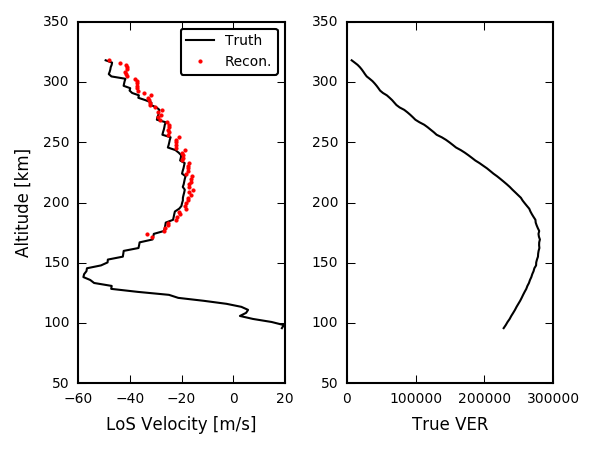

In [191]:
#L21_fn = '/home/bhardin2/MIGHTI/example_level21.npz'
#L21_fn = '/home/bhardin2/MIGHTI/MIGHTI_L21_UIUC_red_002.npz'
#L21_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160117/L21/ICON_MIGHTI_A_ray_UT_3615.00.npz'

# Use file from above:
L21_fn = '/home/bhardin2/MIGHTI/example_level21.npz'

#truth_fn = '/home/bhardin2/MIGHTI/truth_winds_001.npz'
#truth_fn = '/home/bhardin2/MIGHTI/truth_winds_002.npz'
#truth_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150826/Truth_raw/ICON_MIGHTI_A_ray_UT_1845.00.npz'
#truth_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/%s' % (L1_uiuc_fn.split('/')[-1])
#truth_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150522/Truth_raw/%s' % (L1_uiuc_fn.split('/')[-1])
##### Or specify programmatically
#folder = '/'.join(L21_fn.split('/')[:-2])
#base_fn = L21_fn.split('/')[-1]
#truth_fn = '%s/Truth_raw/%s' % (folder,base_fn)

# specify programmatically using file from above code:
folder = '/'.join(L1_uiuc_fn.split('/')[:-2])
base_fn = L1_uiuc_fn.split('/')[-1]
truth_fn = '%s/Truth_raw/%s' % (folder,base_fn)


npzfile = load(truth_fn)
truth_alts = npzfile['tang_alts']
truth_winds = npzfile['truth_winds']
truth_amps = npzfile['truth_amps']
npzfile.close()

subplot(1,2,1)
plot(truth_winds, truth_alts, 'k-', label='Truth')
subplot(1,2,2)
plot(truth_amps, truth_alts, 'k-', label='Truth')
xlabel('True VER')
#xlabel('Some measurement of intensity')
xticks(xticks()[0][::2])

fn = L21_fn
npzfile = load(fn)
wind = npzfile['los_wind']
alt_of_wind = npzfile['alt']
lon = npzfile['lon']
npzfile.close()
subplot(1,2,1)
plot(wind, alt_of_wind, '%s.'%emission_color[0], markersize=3, label='Recon.')
ylabel('Altitude [km]')
xlabel('LoS Velocity [m/s]')
xticks(xticks()[0][::2])
legend(loc='best')
tight_layout()

savefig('/home/bhardin2/public_html/MIGHTI/MIGHTI_L21.png')

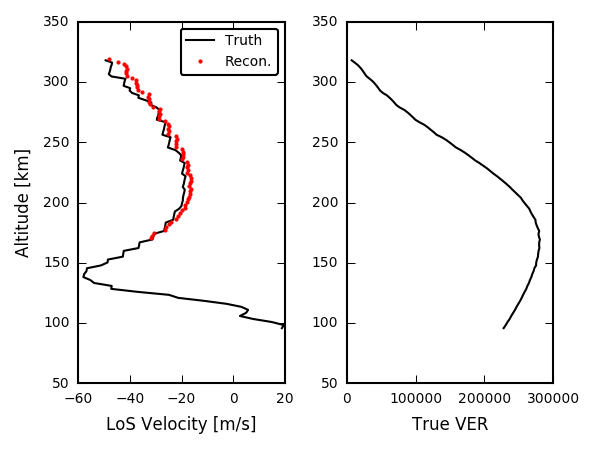

In [165]:
#L21_fn = '/home/bhardin2/MIGHTI/example_level21.npz'
#L21_fn = '/home/bhardin2/MIGHTI/MIGHTI_L21_UIUC_red_002.npz'
#L21_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20160117/L21/ICON_MIGHTI_A_ray_UT_3615.00.npz'

# Use file from above:
L21_fn = '/home/bhardin2/MIGHTI/example_level21.npz'

#truth_fn = '/home/bhardin2/MIGHTI/truth_winds_001.npz'
#truth_fn = '/home/bhardin2/MIGHTI/truth_winds_002.npz'
#truth_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150826/Truth_raw/ICON_MIGHTI_A_ray_UT_1845.00.npz'
#truth_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/%s' % (L1_uiuc_fn.split('/')[-1])
#truth_fn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20150522/Truth_raw/%s' % (L1_uiuc_fn.split('/')[-1])
##### Or specify programmatically
#folder = '/'.join(L21_fn.split('/')[:-2])
#base_fn = L21_fn.split('/')[-1]
#truth_fn = '%s/Truth_raw/%s' % (folder,base_fn)

# specify programmatically using file from above code:
folder = '/'.join(L1_uiuc_fn.split('/')[:-2])
base_fn = L1_uiuc_fn.split('/')[-1]
truth_fn = '%s/Truth_raw/%s' % (folder,base_fn)


npzfile = load(truth_fn)
truth_alts = npzfile['tang_alts']
truth_winds = npzfile['truth_winds']
truth_amps = npzfile['truth_amps']
npzfile.close()

subplot(1,2,1)
plot(truth_winds, truth_alts, 'k-', label='Truth')
subplot(1,2,2)
plot(truth_amps, truth_alts, 'k-', label='Truth')
xlabel('True VER')
#xlabel('Some measurement of intensity')
xticks(xticks()[0][::2])

fn = L21_fn
npzfile = load(fn)
wind = npzfile['los_wind']
alt_of_wind = npzfile['alt']
lon = npzfile['lon']
npzfile.close()
subplot(1,2,1)
plot(wind, alt_of_wind, '%s.'%emission_color[0], markersize=3, label='Recon.')
ylabel('Altitude [km]')
xlabel('LoS Velocity [m/s]')
xticks(xticks()[0][::2])
legend(loc='best')
tight_layout()

savefig('/home/bhardin2/public_html/MIGHTI/MIGHTI_L21.png')

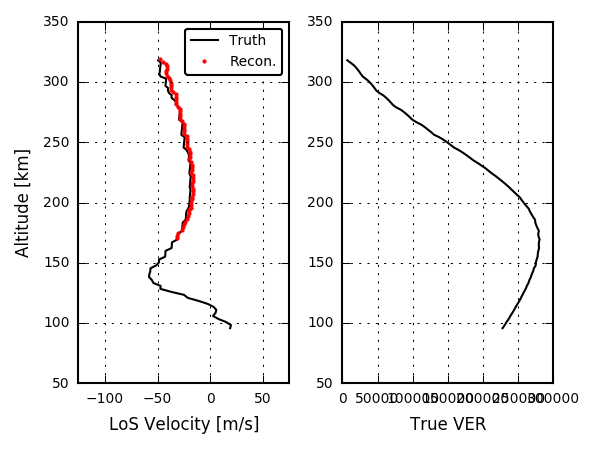

In [166]:
npzfile = load(truth_fn)
truth_alts = npzfile['tang_alts']
truth_winds = npzfile['truth_winds']
truth_amps = npzfile['truth_amps']
npzfile.close()

subplot(1,2,1)
plot(truth_winds, truth_alts, 'k-', label='Truth')
subplot(1,2,2)
plot(truth_amps, truth_alts, 'k-', label='Truth')
xlabel('True VER')
#xlabel('Some measurement of intensity')
#xticks(xticks()[0][::2])
grid()

fn = L21_fn
npzfile = load(fn)
wind = npzfile['los_wind']
alt_of_wind = npzfile['alt']
lon = npzfile['lon']
npzfile.close()
subplot(1,2,1)
plot(wind, alt_of_wind, '%s.'%emission_color[0], markersize=3, label='Recon.')
ylabel('Altitude [km]')
xlabel('LoS Velocity [m/s]')
xlim((nanmedian(wind)-100, nanmedian(wind)+100))
#xticks(xticks()[0][::2])
legend(loc='best')
tight_layout()
grid()

#savefig('/home/bhardin2/public_html/MIGHTI/MIGHTI_L21.png')

In [67]:
# Since this is a truth test, we can test our zero_phase value
emp_zero_wind = nanmean(wind - truth_winds)
emp_zero_phase = emp_zero_wind/instrument['phase_to_wind_factor']
print 'Your zero wind value was off by %.4f m/s' % emp_zero_wind
print 'You should add %.8f to the zero_phase value in order to correct this error' \
         % (emp_zero_phase)

Your zero wind value was off by -0.8705 m/s
You should add -0.00146526 to the zero_phase value in order to correct this error


# L2.1 processing as a single function
##### TODO maybe: put this in MIGHTI_L2.py. Be careful not to have two versions of any code though. For now, copy any changes above to here. This is in progress.

In [180]:
def level21(L1_uiuc_fn, L21_fn, show_plot=True, zero_phase_addition = 0.0, 
            account_for_local_projection=True, top_layer='thin'):

    npzfile = load(L1_uiuc_fn)

    #########################  Load parameters from file #################################
    Ii = npzfile['Ii']
    Ir = npzfile['Ir']
    emission_color = npzfile['emission_color'].item()
    datetime_created = npzfile['datetime_created']
    source_files = npzfile['source_files']
    time = npzfile['time'].item()
    exp_time = npzfile['exp_time']

    # Load parameters which are averaged from start to end of exposure.
    icon_alt = (npzfile['icon_alt_start'] + npzfile['icon_alt_end'])/2
    icon_lat = (npzfile['icon_lat_start'] + npzfile['icon_lat_end'])/2
    icon_lon = MIGHTI_L2.circular_mean(npzfile['icon_lon_start'], npzfile['icon_lon_end'])
    mighti_ecef_vectors = (npzfile['mighti_ecef_vectors_start'] + npzfile['mighti_ecef_vectors_end'])/2
    tang_alt = (npzfile['tang_alt_start'] + npzfile['tang_alt_end'])/2
    tang_lat = (npzfile['tang_lat_start'] + npzfile['tang_lat_end'])/2
    tang_lon = MIGHTI_L2.circular_mean(npzfile['tang_lon_start'], npzfile['tang_lon_end'])
    icon_ecef_ram_vector = (npzfile['icon_ecef_ram_vector_start'] + npzfile['icon_ecef_ram_vector_end'])/2
    icon_velocity = (npzfile['icon_velocity_start'] + npzfile['icon_velocity_end'])/2
    start_path = npzfile['interferometer_start_path']
    end_path   = npzfile['interferometer_end_path']

    npzfile.close()

    
    ######################### Load instrument constants ###########################
    instrument = MIGHTI_L2.get_instrument_constants(emission_color)

    ################# Perform miscellaneous transformations ############################
    Iraw         = Ir + 1j*Ii

    #### Remove Satellite Velocity
    I = MIGHTI_L2.remove_satellite_velocity(Iraw, icon_velocity, icon_ecef_ram_vector, mighti_ecef_vectors, 
                                             instrument['phase_to_wind_factor'], show_plot=False)

    #### Warn about phase discontuity, if applicable
    #MIGHTI_L2.find_phase_discontinuity(I, instrument['min_amp'], instrument['Nignore'])

    #### Determine geographical locations of inverted wind
    lat, lon, alt = MIGHTI_L2.attribute_measurement_location(tang_lat, tang_lon, tang_alt)
    
    #### Onion-peel interferogram (NOTE: option to account for local horizontal projection)
    Ip = MIGHTI_L2.perform_inversion(I, tang_alt, icon_alt, account_for_local_projection=account_for_local_projection, 
                                      zero_phase=instrument['zero_phase'], phase_offset=instrument['phase_offset'],
                                      Nignore=instrument['Nignore'], top_layer=top_layer)

    #### Extract wind
    v_inertial, ve_inertial, a, ae, p = MIGHTI_L2.extract_wind(Ip, instrument['zero_phase'] + zero_phase_addition,
                                                                    instrument['phase_offset'],
                                                                    instrument['min_amp'], 
                                                                    instrument['Nignore'],
                                                                    instrument['phase_to_wind_factor'])


    #### Calculate azimuth angles at measurement locations
    sat_latlonalt = np.array([icon_lat, icon_lon, icon_alt])
    az = MIGHTI_L2.los_az_angle(sat_latlonalt, lat, lon, alt)

    #### Transform from inertial to rotating coordinate frame
    v = MIGHTI_L2.remove_Earth_rotation(v_inertial, az, lat, lon, alt)
    ve = ve_inertial.copy() # No uncertainty added in this process

    #### Make values outside of spec altitudes equal to nan
    #pt = pyglow.Point(time, np.mean(tang_lat), np.mean(tang_lon), np.mean(tang_alt))
    #sza = ICON.get_solar_zenith_angle(pt)
    #day = sza < 90.
    day = True # For now let's use daytime specs
    # Actual spec is red day 170-300, red night 200-300, green day 90-170, green night 90-105
    if day:
        alt_spec = {'red':(170,350), 'green':(80,170)}
    else:
        alt_spec = {'red':(200,350), 'green':(80,105)}
    altmin, altmax = alt_spec[emission_color]
    v[alt < altmin] = np.nan
    v[alt > altmax] = np.nan

    if show_plot:
        plot(v, alt, '%s-' % emission_color[0])
        xlabel('Velocity [m/s]')
        ylabel('Altitude [km]')

    np.savez(L21_fn,
             los_wind                     = v,
             los_wind_error               = ve,
             lat                          = lat,
             lon                          = lon,
             alt                          = alt,
             time                         = time,
             exp_time                     = exp_time,
             az                           = az,
             emission_color               = emission_color,
             resolution_along_track       = None, # TODO
             resolution_cross_track       = None, # TODO
             resolution_alt               = None, # TODO
             icon_alt                     = icon_alt,
             icon_lat                     = icon_lat,
             icon_lon                     = icon_lon,
             fringe_amplitude             = a,
             fringe_amplitude_error       = ae,
             mighti_ecef_vectors          = mighti_ecef_vectors,
             icon_velocity_ecef_vector    = icon_velocity * icon_ecef_ram_vector,
             file_creation_time           = datetime.now(),
             source_files                 = np.concatenate((source_files,[L1_uiuc_fn])),
             )


In [181]:
in_l1_uiuc_fns = glob.glob('/home/bhardin2/MIGHTI/Englandfiles/AB_2016020*/UIUCL1/*.npz')
in_l1_uiuc_fns.sort()

out_l21_fns = []

# create matching output fns
for in_l1_uiuc_fn in in_l1_uiuc_fns:
    path = '/'.join(in_l1_uiuc_fn.split('/')[:-2])
    ncfn = in_l1_uiuc_fn.split('/')[-1]
    fn_without_nc = '.'.join(ncfn.split('.')[:-1])

    out_l21_fn = '%s/L21/%s.npz' % (path,fn_without_nc)
    out_l21_fns.append(out_l21_fn)
    


In [182]:
#in_l1_uiuc_fns

In [183]:
#out_l21_fns

In [184]:
#zero_phase_addition = -118.79998762
zero_phase_addition = 0.0
account_for_local_projection = True
top_layer = 'exp' # 'exp' or 'thin'
show_plot = False
failed_fns = []
for (in_l1_uiuc_fn, out_l21_fn) in zip(in_l1_uiuc_fns, out_l21_fns):
    
    try:
        level21(in_l1_uiuc_fn, out_l21_fn, show_plot, zero_phase_addition, account_for_local_projection, top_layer)
    except Exception as e:
        failed_fns.append(in_l1_uiuc_fn)
        print '%s Failed:\n\t%s' % (in_l1_uiuc_fn,e)
    
    clear_output(wait=True)
    timemod.sleep(0.01)
    print 'Created %s' % out_l21_fn
    sys.stdout.flush()

Created /home/bhardin2/MIGHTI/Englandfiles/AB_20160209/L21/ICON_MIGHTI_B_ray_UT_990.000.npz


# Analyze bulk results of 2.1 inversion against truth

In [131]:
# Choose which l21 files to analyze
l21_fns = out_l21_fns

In [132]:
# find matching truth fns
truth_fns = []
for l21_fn in l21_fns:
    path = '/'.join(l21_fn.split('/')[:-2])
    npzfn = l21_fn.split('/')[-1]

    truth_fn = '%s/Truth_raw/%s' % (path,npzfn)
    truth_fns.append(truth_fn)

/home/bhardin2/MIGHTI/Englandfiles/AB_20160516/Output_1/L21/ICON_MIGHTI_A_ray_UT_1755.00.npz
-42.1191990918


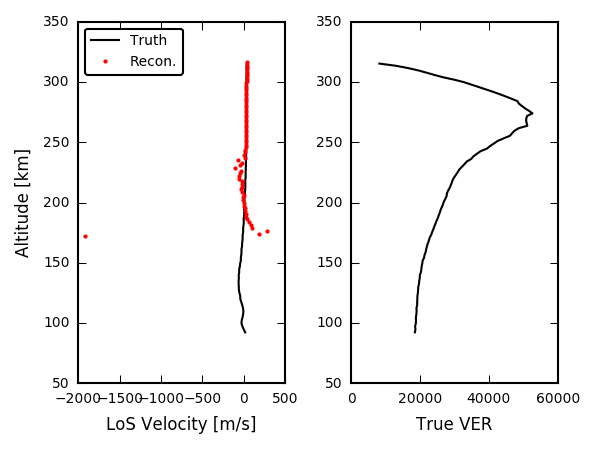

In [137]:
k = 25

l21_fn = l21_fns[k]
truth_fn = truth_fns[k]

print l21_fn


npzfile = load(truth_fn)
truth_alts = npzfile['tang_alts']
truth_winds = npzfile['truth_winds']
truth_amps = npzfile['truth_amps']
npzfile.close()

subplot(1,2,1)
plot(truth_winds, truth_alts, 'k-', label='Truth')
subplot(1,2,2)
plot(truth_amps, truth_alts, 'k-', label='Truth')
xlabel('True VER')
xlim((0,1.1*max(truth_amps)))
xticks(xticks()[0][::2])


npzfile = load(l21_fn)
wind = npzfile['los_wind']
alt = npzfile['alt']
lon = npzfile['lon']
c = npzfile['emission_color'].item()[0]
print mean(lon)
npzfile.close()
subplot(1,2,1)
plot(wind, alt, '%s.'%c  , markersize=3, label='Recon.')
ylabel('Altitude [km]')
xlabel('LoS Velocity [m/s]')
legend(loc='best')
tight_layout()

#savefig('/home/bhardin2/public_html/MIGHTI/MIGHTI_L21.png')

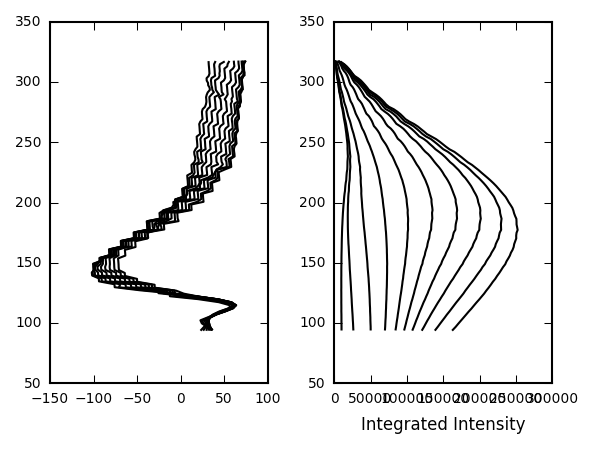

In [138]:
for k in range(10):

    truth_fn = truth_fns[k]


    npzfile = load(truth_fn)
    truth_alts = npzfile['tang_alts']
    truth_winds = npzfile['truth_winds']
    truth_amps = npzfile['truth_amps']
    npzfile.close()

    subplot(1,2,1)
    plot(truth_winds, truth_alts, 'k-', label='Truth')
    subplot(1,2,2)
    plot(truth_amps, truth_alts, 'k-', label='Truth')
    xlabel('Integrated Intensity')
    #xlim((0,1.1*max(truth_amps)))
    #xticks(xticks()[0][::2])

    tight_layout()

#savefig('/home/bhardin2/public_html/MIGHTI/MIGHTI_L21.png')

In [139]:
Afns = glob.glob('/home/bhardin2/MIGHTI/Englandfiles/AB_20160516/Output_1/L21/ICON_MIGHTI_A_*')
Bfns = glob.glob('/home/bhardin2/MIGHTI/Englandfiles/AB_20160516/Output_1/L21/ICON_MIGHTI_B_*')


# Sort the files by time
tvec = [load(fn)['time'].item() for fn in Afns]
keydict = dict(zip(Afns, tvec))
Afns.sort(key=keydict.get)

tvec = [load(fn)['time'].item() for fn in Bfns]
keydict = dict(zip(Bfns, tvec))
Bfns.sort(key=keydict.get)

# 05: Ignore the first few files, where we experience a +/-180 deg crossover in longitude
#Afns = Afns[:100]
#Bfns = Bfns[11:100]
# 12: Ignore first files, which occur before +/- 180 deg crossover
#Afns = Afns[60:]
#Bfns = Bfns[60:]
# Only use the first few files
#Afns = Afns[30:60]
#Bfns = Bfns[30:60]
# Only use the last few files
#Afns = Afns[-25:]
#Bfns = Bfns[-26:]

In [140]:
# Find matching truth fns
A_truth_fns = []
for l21_fn in Afns:
    path = '/'.join(l21_fn.split('/')[:-2])
    npzfn = l21_fn.split('/')[-1]

    truth_fn = '%s/Truth_raw/%s' % (path,npzfn)
    A_truth_fns.append(truth_fn)
    
B_truth_fns = []
for l21_fn in Bfns:
    path = '/'.join(l21_fn.split('/')[:-2])
    npzfn = l21_fn.split('/')[-1]

    truth_fn = '%s/Truth_raw/%s' % (path,npzfn)
    B_truth_fns.append(truth_fn)

In [141]:
def load_l21(fns):
    '''
    Crawl the list of files given, and return N x K matrices of:
        latitude
        longitude
        altitude
        los_wind
        local_az
    where N = number of altitude bins 
          K = number of time samples (i.e., len(fns))
    Also return a vector containing the time (as a datetime object)
    '''
    N_altbins = len(load(fns[0])['alt'])
    lat = zeros((N_altbins, len(fns)))
    lon = zeros((N_altbins, len(fns)))
    alt = zeros((N_altbins, len(fns)))
    los_wind = zeros((N_altbins, len(fns)))
    local_az = zeros((N_altbins, len(fns)))
    time = zeros(len(fns), dtype=object)

    for i in range(len(fns)):
        fn = fns[i]
        npzfile = load(fn)

        # Extract all information from the L2.1 file
        emission_color = str(npzfile['emission_color'])
        icon_alt = npzfile['icon_alt']
        icon_lat = npzfile['icon_lat']
        icon_lon = npzfile['icon_lon']
        alti = npzfile['alt']
        lati = npzfile['lat']
        loni = npzfile['lon']
        azi = npzfile['az']
        los_windi = npzfile['los_wind']
        timei = npzfile['time'].item()
        datetime_created = npzfile['file_creation_time'].item()
        source_files = npzfile['source_files']

        lat[:,i] = lati
        lon[:,i] = loni
        alt[:,i] = alti
        los_wind[:,i] = los_windi
        local_az[:,i] = azi
        time[i] = timei
        npzfile.close()    
    
    return lat, lon, alt, los_wind, local_az, time


In [142]:
def load_truth(fns):
    '''
    Crawl the list of truth files given, and return N x K matrices of:
        altitude
        los_wind
    where N = number of altitude bins 
          K = number of time samples (i.e., len(fns))
    '''
    N_altbins = len(load(fns[0])['tang_alts'])
    alt_A = zeros((N_altbins, len(fns)))
    los_wind_A = zeros((N_altbins, len(fns)))
    amp_A =  zeros((N_altbins, len(fns)))
    
    for i in range(len(fns)):
        fn = fns[i]
        npzfile = load(fn)

        # Extract all information from the L2.1 file
        truth_alts = npzfile['tang_alts']
        truth_winds = npzfile['truth_winds']
        truth_amps = npzfile['truth_amps']

        alt_A[:,i] = truth_alts
        los_wind_A[:,i] = truth_winds
        amp_A[:,i] = truth_amps
        npzfile.close()    
    
    return alt_A, los_wind_A, amp_A

### The following assumes that the bottom of the shell is the same as the middle. The correct thing to would be interpolation.

In [143]:
# Choose to load A or B
lat_A, lon_A, alt_A, los_wind_A, local_az_A, time_A = load_l21(Bfns)
alt_A_truth, los_wind_A_truth, amp_A_truth = load_truth(B_truth_fns)

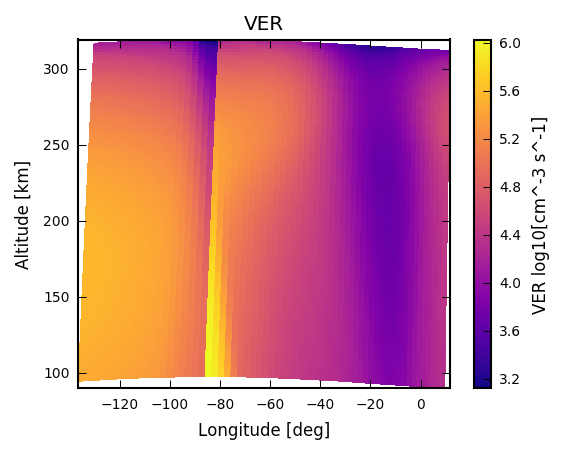

In [144]:
pcolormesh(lon_A,alt_A,log10(amp_A_truth), cmap='plasma')
axis('tight');
xlabel('Longitude [deg]')
ylabel('Altitude [km]')
cb = colorbar()
cb.set_label('VER log10[cm^-3 s^-1]')
title('VER')
#clim((0,amp_A_truth.max()))
#clim((-3,1.6))

#savefig('/home/bhardin2/MIGHTI/NRL_instr_model/my_VER.png', dpi=200)

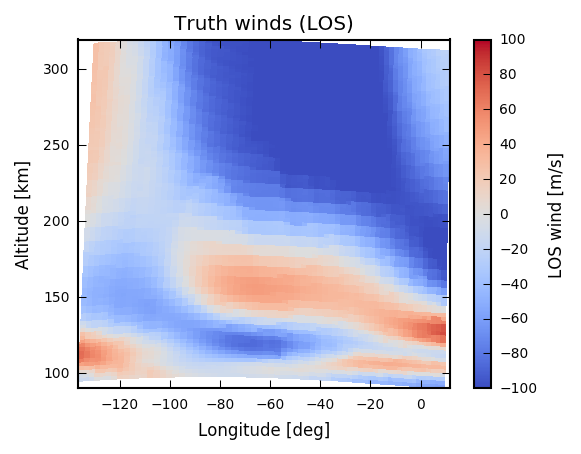

In [145]:
pcolormesh(lon_A,alt_A,los_wind_A_truth, cmap='coolwarm')
axis('tight');
xlabel('Longitude [deg]')
ylabel('Altitude [km]')
cb = colorbar()
cb.set_label('LOS wind [m/s]')
title('Truth winds (LOS)')
cminmax = (-100,100)
clim(cminmax)

#ylim((85,320))
#xlim((-112,39))

#savefig('/home/bhardin2/MIGHTI/NRL_instr_model/my_truth.png', dpi=200)

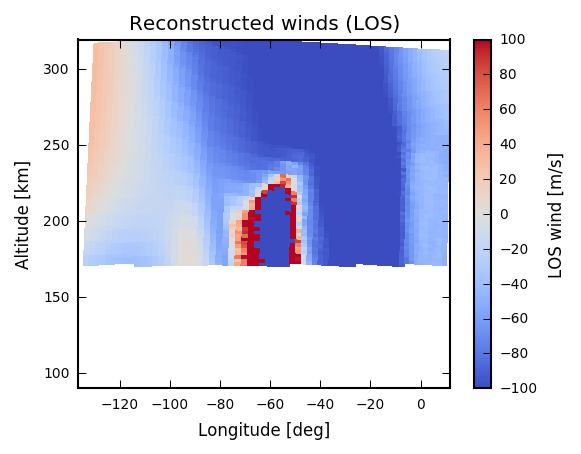

In [147]:
M = ma.masked_array(los_wind_A, isnan(los_wind_A))
pcolormesh(lon_A, alt_A, M, cmap='coolwarm')
axis('tight');
xlabel('Longitude [deg]')
ylabel('Altitude [km]')
title('Reconstructed winds (LOS)')
cb = colorbar()
cb.set_label('LOS wind [m/s]')
clim(cminmax)
#ylim((85,320))
#xlim((-112,39))

#savefig('/home/bhardin2/MIGHTI/NRL_instr_model/my_reconstructed.png', dpi=200)

In [148]:
los_wind_A_err = los_wind_A - los_wind_A_truth

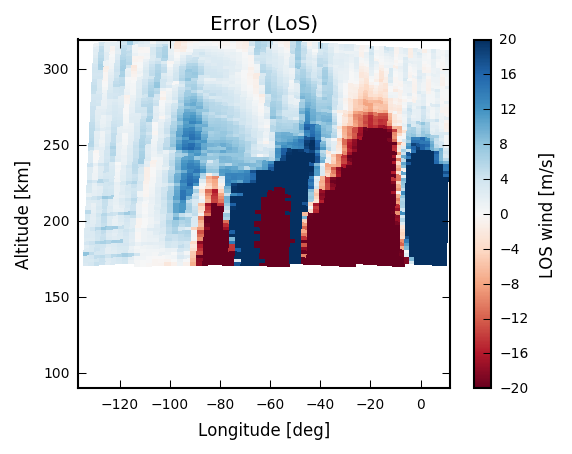

In [149]:
M = ma.masked_array(los_wind_A_err, isnan(los_wind_A_err))
pcolormesh(lon_A,alt_A, M, cmap='RdBu')
axis('tight');
xlabel('Longitude [deg]')
ylabel('Altitude [km]')
title('Error (LoS)')
cb = colorbar()
cb.set_label('LOS wind [m/s]')
clim((-20,20))
#ylim((85,320))
#xlim((-112,39))
#savefig('/home/bhardin2/MIGHTI/NRL_instr_model/my_error.png', dpi=200)

In [150]:
shape(lon_A)

(101, 66)

-122.221206665
3.65 m/s rms error


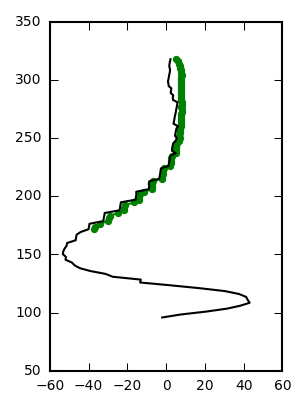

In [151]:
i = 5

print lon_A[50,i]
figure(figsize=(2,3))
plot(los_wind_A[:,i]      ,alt_A[:,i],'g.-')
plot(los_wind_A_truth[:,i],alt_A[:,i],'k-')
err = los_wind_A[:,i]-los_wind_A_truth[:,i]
erms = sqrt(nanmean(err**2))
print '%.2f m/s rms error' % erms